In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})


In [2]:
from scipy.constants import e, m_p, c

In [3]:
from cpymad.madx import Madx

import sixtracklib as pyst
import pysixtrack

In [4]:
madx = Madx()
madx.options.echo = False
madx.options.warn = False
madx.options.info = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.10.24 17:33:16      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [5]:
madx.call('./SIS100_RF_220618_9slices.thin.seq')

In [6]:
from scipy.constants import physical_constants

In [7]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
nmass = 0.931494061 # MAD-X value

In [8]:
A = 238
Q = 28

Ekin_per_nucleon = 0.2e9 # in eV

###

mass = A * nmass * 1e9 * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)

In [9]:
madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=Etot)

True

In [10]:
madx.call('./OpticsYEH_BeamParameters.str')

In [11]:
madx.use(sequence='sis100ring')

In [12]:
madx.input('''
match, sequence=SIS100RING;
global, sequence=SIS100RING, q1=18+0.84, q2=18+0.73;
vary, name=kqf, step=0.00001;
vary, name=kqd, step=0.00001;
lmdif, calls=500, tolerance=1.0e-10;
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   8.49283167e-16





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.80997e-01  2.81571e-01 -1.00000e+20  1.00000e+20
kqd                      -2.79858e-01 -2.80616e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   8.49283167e-16


True

In [13]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004051660019        15.71026469 

                q1                dq1            betxmax              dxmax 
             18.84       -39.80511805        19.95816218        3.140998962 

             dxrms             xcomax             xcorms                 q2 
        1.38648703                  0                  0              18.73 

               dq2            betymax              dymax              dyrms 
      -39.71639486        21.30632346                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [14]:
madx.use(sequence='SIS100RING')

In [15]:
madx.input('''
select, flag=seqedit, class=collimator;
select, flag=seqedit, class=hmonitor;
select, flag=seqedit, class=vmonitor;
select, flag=seqedit, class=kicker;
select, flag=seqedit, class=tkicker;
! select, flag=seqedit, class=dipedge;
select, flag=seqedit, class=elseparator;

seqedit, sequence=SIS100RING;
    remove, element=selected;
    flatten;
endedit;

select, flag=seqedit, class=marker;
seqedit, sequence=SIS100RING;
    remove, element=selected;
    install, element=SIS100RING$START, s=0;
    flatten;
endedit;
''')

madx.use(sequence='SIS100RING')

In [16]:
sis100 = madx.sequence.sis100ring

In [17]:
# np.unique([f.name for f in map(lambda x: x.base_type, sis100.expanded_elements) 
#  if 'drift' != f.name and 'multipole' != f.name and 'rfcavity' != f.name])

In [18]:
pysixtrack_elements, _ = pysixtrack.Line.from_madx_sequence(
    sis100, exact_drift=True, ignored_madtypes=[
        'collimator', 'kicker', 'elseparator']
)

In [19]:
# pysixtrack_elements.remove_zero_length_drifts(inplace=True);

In [20]:
# pysixtrack_particles = pysixtrack.Particles(p0c=p0c)

# pysixtrack_particles.x += 1e-6

# pysixtrack_elements.track(pysixtrack_particles)

In [21]:
elements = pyst.Elements.from_line(pysixtrack_elements)

In [22]:
len(elements.get_elements())

4039

$~$

$~$

$~$

$~$

In [25]:
nturns = 2**16
elements.BeamMonitor(num_stores=nturns);

In [26]:
npart = 1
particles = pyst.Particles.from_ref(npart, p0c=p0c)

In [27]:
particles.x += 1e-6
particles.y += 1e-6

In [28]:
job = pyst.TrackJob(elements, particles)

In [29]:
job.track_until(nturns)

0

In [30]:
job.collect()

In [31]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

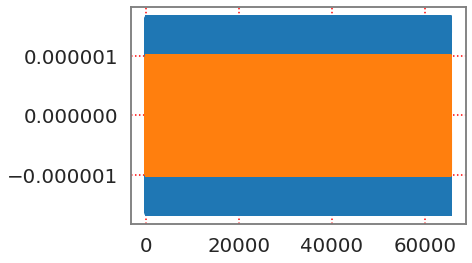

In [32]:
plt.plot(rec_x)
plt.plot(rec_y)

In [33]:
Qx = twiss.summary['q1']
qx = Qx % 1
qx = qx if qx < 0.5 else 1 - qx

Qy = twiss.summary['q2']
qy = Qy % 1
qy = qy if qy < 0.5 else 1 - qy

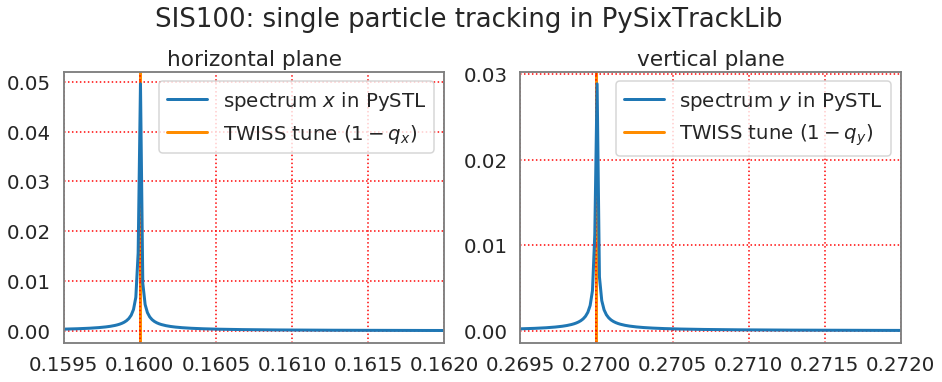

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal plane')
plt.plot(
    np.fft.rfftfreq(len(rec_x)),
    np.abs(np.fft.rfft(rec_x)),
    label=r'spectrum $x$ in PySTL'
)
plt.axvline(qx, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_x)$')
plt.xlim(qx - 0.0005, qx + 0.002)
plt.legend()

plt.sca(ax[1])
plt.title('vertical plane')
plt.plot(
    np.fft.rfftfreq(len(rec_y)),
    np.abs(np.fft.rfft(rec_y)),
    label=r'spectrum $y$ in PySTL'
)
plt.axvline(qy, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_y)$')
plt.xlim(qy - 0.0005, qy + 0.002)
plt.legend()

plt.suptitle('SIS100: single particle tracking in PySixTrackLib', y=1.06, fontsize=26)
plt.savefig('./pystl_sis100_tunes.pdf', bbox_inches='tight')